In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import utils

In [2]:
# q1, q2: shape(3, n) n homogenous 2D points
# using point correspondances from img1 (q1) and img2 (q2) to est. F
# NOTE: n must be at least 8
def Fest_8point(q1, q2):
    B = []
    for i in range(q1.shape[1]):
        q1i = np.expand_dims(q1[:,i], axis=0)
        q2i = np.expand_dims(q2[:,i], axis=0)
        B.append((q1i.T @ q2i).flatten())
    B = np.vstack(B)
    U, S, VT = np.linalg.svd(B, full_matrices=True)
    F_flat = VT[-1]
    F = F_flat.reshape((3, 3)).T
    return F

In [3]:
d1 = np.load('Fest_test.npy', allow_pickle=True).item()
q1 = d1['q1']
q2 = d1['q2']
Ftrue = d1['Ftrue']

In [4]:
Fest = Fest_8point(q1, q2)
print(Ftrue)
Fest = Fest * Ftrue[0][0] / Fest[0][0]
print(Fest)


[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
[[ 6.67972386e-12 -7.85049968e-10  1.17921973e-07]
 [-9.75936981e-10 -4.86806511e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002229e-04]]


In [5]:
d2 = np.load('TwoImageData.npy', allow_pickle=True).item()
im1 = d2['im1']
R1 = d2['R1']
t1 = d2['t1']
im2 = d2['im2']
R2 = d2['R2']
t2 = d2['t2']
K = d2['K']
# From exercise 3 - 3.7
# To find the relative transformation from cam 1 to cam 2
R = R2 @ R1.T
t = t2 - R2@R1.T@t1
E = utils.crossOp(t.T)@R
Ftrue = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
print(Ftrue)

[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


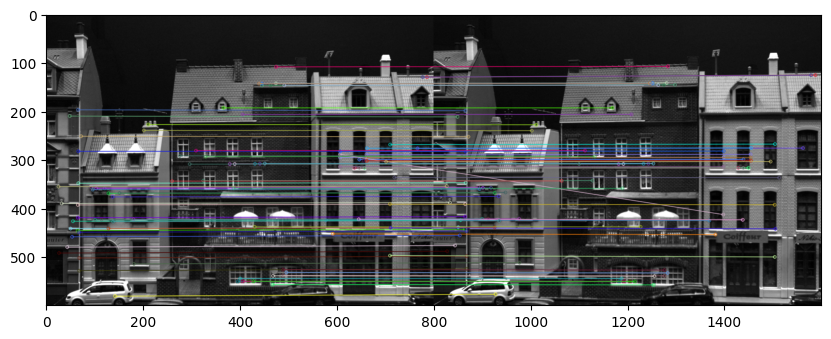

In [6]:
sift = cv2.SIFT.create()
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)
im1_kps = cv2.drawKeypoints(im1, kp1, None)
im2_kps = cv2.drawKeypoints(im2, kp2, None)

bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
sorted_matches = sorted(matches, key = lambda x:x.distance)

mimg = cv2.drawMatches(im1, kp1, im2, kp2, sorted_matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg)

In [7]:
def SampsonsDistance(F, p1, p2):
    return (p2.T@F@p1)**2 / ((p2.T@F)[0][0]**2 + (p2.T@F)[0][1]**2 + (F@p1)[0][0]**2 + (F@p1)[1][0]**2)

def get_inliers(matches, kps1, kps2, F, sigma):
    kps1 = [kps1[match.queryIdx].pt for match in matches]
    kps2 = [kps2[match.trainIdx].pt for match in matches]
    inliers = []
    min = math.inf
    for i in range(len(kps1)):
        kp1 = np.expand_dims(np.asarray(kps1[i]), axis=0).T
        kp2 = np.expand_dims(np.asarray(kps2[i]), axis=0).T
        err = SampsonsDistance(F, utils.PiInv(kp1), utils.PiInv(kp2))
        if err < min: min = err
        if err < 3.84*sigma**2: inliers.append(i)
    return inliers

In [8]:
def ransac(matches, kp1, kp2, N, sigma):
    best_inl = []
    for i in range(N):
        sample_kp1, sample_kp2 = utils.sample(matches, kp1, kp2, size=8)
        F = Fest_8point(utils.PiInv(sample_kp1), utils.PiInv(sample_kp2))
        inliers = get_inliers(matches, kp1, kp2, F, sigma)
        if len(inliers) > len(best_inl):
            best_inl = inliers
    print(f'Num of inliers: {len(best_inl)}')
    return F, best_inl

In [9]:
F_ransac, best_inl = ransac(matches, kp1, kp2, 200, 3)
print('F')
print(F_ransac * Ftrue[0][0] / F_ransac[0][0])

Num of inliers: 1929
F
[[ 6.67972386e-12 -1.21797102e-09  1.79357118e-07]
 [ 1.12766893e-09 -1.14615866e-10  1.32401071e-06]
 [-1.55997679e-07 -1.22385649e-06 -1.77903529e-05]]


In [10]:
kps1 = [kp1[matches[i].queryIdx].pt for i in best_inl]
kps2 = [kp2[matches[i].trainIdx].pt for i in best_inl]
F_est = Fest_8point(utils.PiInv(np.asarray(kps1).T), utils.PiInv(np.asarray(kps2).T))
F_est = F_est * Ftrue[0][0] / F_est[0][0]
print('F true')
print(Ftrue)
print('F est')
print(F_est)

F true
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
F est
[[ 6.67972386e-12  8.12372351e-11 -3.50360317e-08]
 [-4.21068538e-13  3.97450186e-11 -1.11296688e-06]
 [ 2.64894239e-09  1.05198634e-06  1.58576534e-05]]


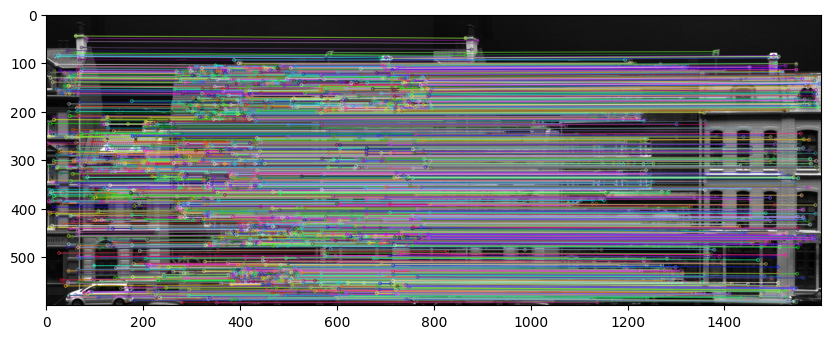

In [11]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

inMatches = np.array([matches])[0, best_inl][:]
inMatches = totuple(inMatches)

mimg2 = cv2.drawMatches(im1, kp1, im2, kp2, inMatches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg2)

The fundamental matrix applies a constraint on filtering the matches: the inliers can be considered the true matches.